# TrySelectingMetricSpatially #

**Started 2016-04-27** -- Try loading a previously-evaluated metric and selecting on spatial regions.

Here's how I imagine this working:

* Load the metric of interest, assign RA, DEC values to each healpix and use astropy to convert (RA, DEC) --> (l, b);

* To select regions, either:

    * Parameterize the region somehow and use naiive selection on the plane; or,

    * Compute (or load) a stellar density map - say, rmag < 28 as in PeterY's **StellarDensityMap.ipynb** in **maf_contrib** - for the same opsimdb file and NSIDE as the metric we want, and use density to select.

* Boolean-select on |b| and on density

* Select metric values (a 1D array) on the boolean resulting;

* Do statistics on that sample.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

In [33]:
from matplotlib.colors import LogNorm

In [3]:
# healpy 
import healpy as hp

In [4]:
# Loading pre-ran metric results
import lsst.sims.maf.metricBundles as mb

In [5]:
# import statements from the plot-handling notebook
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metricBundles import MetricBundle, MetricBundleGroup, makeBundlesDictFromList

In [6]:
# Copied file sims_utils/python/lsst/sims/utils/healpyUtils.py into the working directory
import healpyUtils

In [7]:
# Some stuff we'll need to manipulate coordinates easily
from astropy.coordinates import SkyCoord

### Set the source path for precomputed metric output ###

In [8]:
# uncomment to follow the convention of the repository. 
# Note that then the outputs will be submittable to the repository.

#topDir = '/Users/clarkson/Progs/Projects/lsstScratchWIC'
#metricDir = '%s/data/metricOutputs' % (topDir)

# Otherwise we assume this is already being run from the directory 
# holding pre-computed metric directories.
metricDir=os.getcwd()

In [9]:
# Let's set metricDir to a particular place...
inputDir='%s/metricEvals/minion_1016_nside64_ugrizy_n10000_r21p0_lims' % (metricDir)
inputFil='minion_1016_properMotion_night_lt_10000_HEAL.npz'

## Test loading pre-computed metric ##

In [10]:
# check that we can read the path
inPath = '%s/%s' % (inputDir, inputFil)
print os.access(inPath, os.R_OK)

True


In [11]:
myBundle = mb.createEmptyMetricBundle()

In [12]:
myBundle.read(inPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Test plotting the spatial map for this metric bundle ##

In [13]:
print myBundle.metric.name

properMotion


In [14]:
print myBundle.metric.colInfo

In [15]:
# Can we choose which plots to produce?
# help(myBundle.setPlotFuncs)   ## Yes but is not immediately obvious to me...
print myBundle.plotFuncs  # can we change this?
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()] #, plots.HealpixSDSSSkyMap()]
myBundle.setPlotFuncs(plotFuncs)

[<lsst.sims.maf.plots.spatialPlotters.HealpixSkyMap object at 0x114f9c750>, <lsst.sims.maf.plots.spatialPlotters.HealpixHistogram object at 0x114f9c650>, <lsst.sims.maf.plots.spatialPlotters.HealpixPowerSpectrum object at 0x114f9ca90>]


/Users/clarkson/Progs/python/LSST/sims_maf_github/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 1703 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


{'Histogram': 2, 'SkyMap': 1}

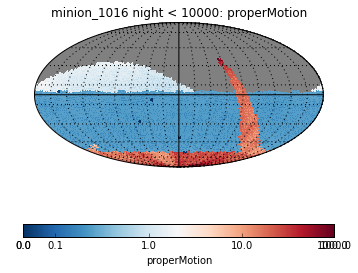

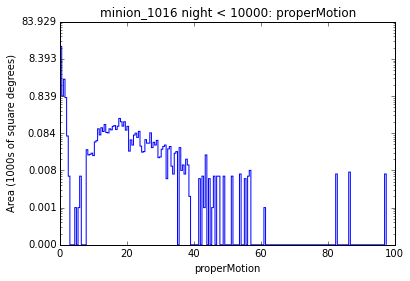

In [16]:
# aha - so we CAN just plot by calling the method!! Niiice... OK now see if we can change any parameters
thisPlotDict = {'logScale':True, 'cmap':cm.RdBu_r}
myBundle.setPlotDict(thisPlotDict)
myBundle.plot()

## Try lifting spatial information out ## 

Following an idea suggested by Peter Yoachim using healpy and healpyUtils.py to do co-ordinate conversion

In [17]:
npix = myBundle.metricValues.size
nside = hp.npix2nside(npix)
print npix, nside

49152 64


In [24]:
ra, dec = healpyUtils.hpid2RaDec(nside, np.arange(npix))
print np.shape(ra)
print np.shape(dec)
print np.min(ra), np.max(ra)
print np.min(dec), np.max(dec)

(49152,)
(49152,)
0.0 359.296875
-89.2690292916 89.2690292916


In [25]:
# feed these RA, DEC values into an astropy coords object
cc = SkyCoord(ra=np.copy(ra), dec=np.copy(dec), frame='fk5', unit='deg')

### Try test-plotting using something basic ###

In [20]:
np.shape(myBundle.metricValues)

(49152,)

In [121]:
def getAvoidanceLatitudes(galL, peakDeg=10., taperDeg=80., constWidth=5.):
    
    """Returns the (positive) GP avoidance region for input galactic longitude"""
    
    # The following is adapted from spatialPlotters.py in sims_maf, method _plot_mwZone
    
    # astropy uses 0 <= glon <= 2pi, so we shift the input values accordingly.
    galL_use = np.copy(galL)
    gSec = np.where(galL_use > np.pi)
    galL_use[gSec] -= 2.0 * np.pi
    
    peakWidth=np.radians(peakDeg)
    taperLength=np.radians(taperDeg)
    val = peakWidth * np.cos(galL_use / taperLength * np.pi / 2.)
    
    # For the positive quadrant...
    gFar = np.where(np.abs(galL_use) > taperLength)[0]
    val[gFar] = 0.

    val += np.radians(constWidth)
    
    return val

In [159]:
# now try selecting spatially for (region, ~region)
mVals = myBundle.metricValues  # view for convenience
gLon = np.asarray(cc.galactic.l)
gLat = np.asarray(cc.galactic.b)

latAvoidPos = getAvoidanceLatitudes(gLon*np.pi/180., constWidth=0.0)
latAvoidPos *= 180./np.pi

bPln = (gLat < latAvoidPos) & (gLat > 0.-latAvoidPos)
bAway = ~bPln

print np.size(np.where(~bPln))

46730


<matplotlib.colorbar.Colorbar instance at 0x1380ffc20>

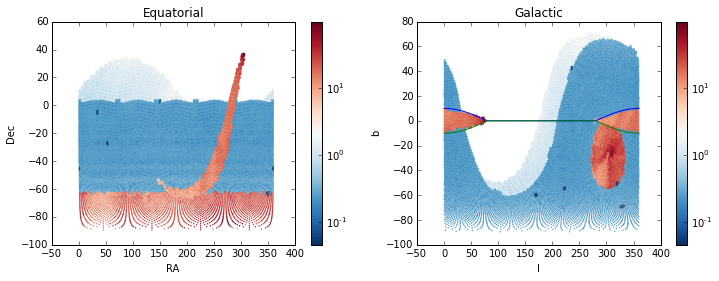

In [160]:
# Chart the avoidance regions for the plane:
step = 0.02
galL = np.arange(-np.pi, np.pi + step / 2., step) + np.pi
galB1 = getAvoidanceLatitudes(galL, 10., 80., 0.)
galB2 = 0. - galB1

# all in degrees
r2deg = 180./np.pi
galL *= r2deg
galB1 *= r2deg
galB2 *= r2deg

plt.figure(1, figsize=(12,4))
plt.clf()
plt.subplot(121)
plt.scatter(cc.ra, cc.dec, \
            c=myBundle.metricValues, edgecolor='none', s=2, \
           cmap=cm.RdBu_r, norm=LogNorm())
plt.title('Equatorial')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

plt.subplot(122)
plt.scatter(cc.galactic.l, cc.galactic.b, \
            c=myBundle.metricValues, edgecolor='none', s=2, \
           cmap=cm.RdBu_r, norm=LogNorm())

plt.plot(galL, galB1)
plt.plot(galL, galB2)

plt.title('Galactic')
plt.xlabel('l')
plt.ylabel('b')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x138b758c0>

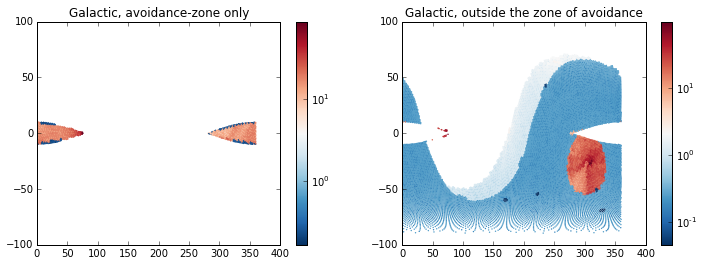

In [161]:
# Let's try that again, this time sticking with galactics and selecting out our regions.
plt.figure(2, figsize=(12,4))
plt.clf()
plt.subplot(121)
plt.scatter(cc.galactic.l[bPln], cc.galactic.b[bPln], \
            c=myBundle.metricValues[bPln], edgecolor='none', s=2, \
           cmap=cm.RdBu_r, norm=LogNorm())

plt.xlim(0, 400)
plt.ylim(-100,100)
plt.title('Galactic, avoidance-zone only')
plt.colorbar()

plt.subplot(122)
plt.scatter(cc.galactic.l[~bPln], cc.galactic.b[~bPln], \
            c=myBundle.metricValues[~bPln], edgecolor='none', s=2, \
           cmap=cm.RdBu_r, norm=LogNorm())

plt.xlim(0, 400)
plt.ylim(-100,100)
plt.title('Galactic, outside the zone of avoidance')
plt.colorbar()

## Compute statistics on the input metric ##

In [162]:
# in the region of interest...
print np.median(myBundle.metricValues[bPln])
print np.std(myBundle.metricValues[bPln])
#print myBundle.metricValues[bPln]

15.7318896212
8.16822700154


In [163]:
# NOT in the region of interest...
print np.median(myBundle.metricValues[~bPln])
print np.std(myBundle.metricValues[~bPln])
#print myBundle.metricValues[~bPln]

0.242782986716
7.40593421256


**WARNING** - histogram may be a bit dangerous, I don't remember if the healpix area needs to be taken into account on the sky... 

/Users/clarkson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/clarkson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


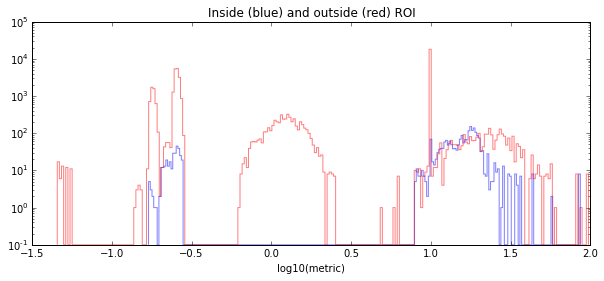

In [166]:
plt.figure(3, figsize=(10,4))
plt.clf()

dum = plt.hist(np.log10(myBundle.metricValues[bPln]), bins=250, \
               alpha=0.5, log=True, color='b', \
              histtype='step', normed=False)
dum = plt.hist(np.log10(myBundle.metricValues[~bPln]), bins=250, \
               alpha=0.5, log=True, color='r', \
              histtype='step', normed=False)

plt.xlabel('log10(metric)')
plt.title('Inside (blue) and outside (red) ROI')

**To be continued...**

In [165]:
! pwd

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411
